<a href="https://colab.research.google.com/github/theocharistr/deeplearning-assignments/blob/master/Theocharis_Triantafyllidis_Assignment_1_E_Super_resolution_on_BSDS300.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1/E
**Disclaimer: Only for ADL/AML students!**

### General information
**You have to solve all tasks to pass!** 

Grade is calculated by the day of the last submission, but you will only get it after you've succesfully presented it. 

**Deadlines and grades:** 
  * 2020.09.20 - 2020.10.20 ==> 5
  * 2020.10.21 - 2020.10.27 ==> 4
  * 2020.10.28 - 2020.11.03 ==> 3
  * 2020.11.04 - 2020.11.10 ==> 2
  * 2020.11.11 or later ==> 1 

You can **use only these** 3rd party **packages:** `cv2, pandas, keras, matplotlib, numpy, sklearn, skimage, tensorflow`.

### Description
In this assignment you have to build a model for super-resolution using tf.keras. You have to train a CNN to upscale small image patches, then use the trained model to upscale full images. To implement such kind of model, you should take a look at the following classes and methods: `Sequential model, Funcitonal API, Conv2D, cv2.cvtColor (BGR2YCrCb, YCrCb2RGB, YCrCb2BGR)`.


## Prepare dataset

### BSDS300
* LR: Low resolution, HR: high resolution, SR: super resolution
* Download the BSDS300 dataset. Here you can find more information about the dataset: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/
* After extracting it, convert them to YCrCb color space. We will use the luminance information (0th channel) only as the input of the CNN.
* Create 32x32 image patches with a sliding window (16 step size).
* Use 0.15 part of the train set as the validation set.
* The Y (0th) channel of the original images will be the ground truth. Create the LR images by resizing them half of the original size, then resize it back to the original size using cubic interpolation.
* Print the size of each set and plot 5 LR training images and their corresponding HR images. *Note: Don't forget to convert the color space from YCrCb back to RGB before plotting.*
* Normalize the datasets. All value should be between 0.0 and 1.0. *Note: you don't have to use standardization, you can just divide them by 255.*

In [ ]:
# BSDS300 dataset
!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300-images.tgz
!tar -xvzf BSDS300-images.tgz

--2020-10-22 19:55:09--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300-images.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.189.73
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22211847 (21M) [application/x-tar]
Saving to: ‘BSDS300-images.tgz.14’

BSDS300-images.tgz. 100%[===================>]  21.18M  10.2MB/s    in 2.1s    

2020-10-22 19:55:12 (10.2 MB/s) - ‘BSDS300-images.tgz.14’ saved [22211847/22211847]

BSDS300/images/
BSDS300/images/train/
BSDS300/images/train/159029.jpg
BSDS300/images/train/20008.jpg
BSDS300/images/train/155060.jpg
BSDS300/images/train/286092.jpg
BSDS300/images/train/100075.jpg
BSDS300/images/train/61060.jpg
BSDS300/images/train/46076.jpg
BSDS300/images/train/301007.jpg
BSDS300/images/train/26031.jpg
BSDS300/images/train/232038.jpg
BSDS300/images/train/45077.jpg
BSDS300/images/train/365025.jpg


In [ ]:
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import skimage
import sklearn
import PIL
import PIL.Image
import os
import glob


Access folder paths.

In [ ]:
path='/content/BSDS300/images'
test_data=path+'/test'
train_data=path+'/train'
print(test_data)

/content/BSDS300/images/test


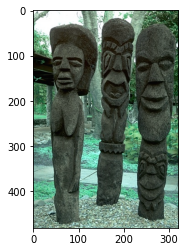

481   321


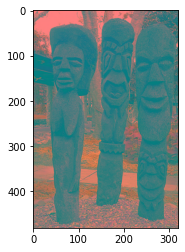

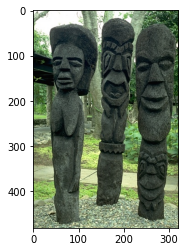

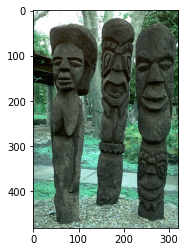

In [ ]:
def convertBGR2YCrCb(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)


def convertYCrCb2RGB(image):
  return cv2.cvtColor(image,cv2.COLOR_YCrCb2RGB)


def convertYCrCb2BGR(image):
  return cv2.cvtColor(image,cv2.COLOR_YCrCb2BGR)

 
img = cv2.imread('/content/BSDS300/images/test/101085.jpg')

plt.imshow(img)
plt.show()
h, w, d= img.shape
print(h," ",w)

newimg=convertBGR2YCrCb(img)
plt.imshow(newimg)
plt.show()

newimg2=convertYCrCb2RGB(newimg)
plt.imshow(newimg2)
plt.show()

newimg3=convertYCrCb2BGR(newimg)
plt.imshow(newimg3)
plt.show()
  


Convert the images to YCrCb,

Create 32x32 image patches with a sliding window (16 step size),

Save them as training set,

Create patches for the test set.




5170
2670


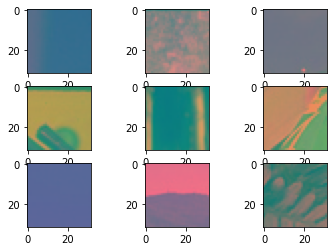

In [ ]:
def ConvertData(data):
  patches = []
  for file in glob.glob(data + '/*.jpg'):
    img = cv2.imread(file)
    newimg = convertBGR2YCrCb(img)
    height, width, depth = newimg.shape
    h,w = 0,0
    patchSize = 32
    step = 16
    while( h < height and (height - h > patchSize)):
      while(w < width and (width - w > patchSize)):
        patch = newimg[h:h+patchSize, w:w+patchSize]
        patches.append(patch)
        w = w + step
      h = h + step
  return patches  

patches= ConvertData(train_data)
#size of training data now
print(len(patches))
rand = np.random.choice(len(patches), 9)

plt.figure()
for x, y in enumerate(rand):
  plt.subplot(3, 3, x+1)
  plt.imshow(patches[y])
 
testpatches = ConvertData(test_data)
#Size of test data now
print(len(testpatches))


Create the Low Resolution images by resizing them half of the original size, then resize it back to the original size using cubic interpolation. 

In [ ]:
def createLR(img):  
  return cv2.resize(img,( int(img.shape[1]/2) , int(img.shape[0]/2)))

def createCubicInterpolation(img):
  return cv2.resize(img, (img.shape[1]*2,img.shape[0]*2), interpolation=cv2.INTER_CUBIC)

LRimages=[] #Low resolution images after cubic interpolation
ORimages=[] #Original / High resolution images
for file in glob.glob(test_data + '/*.jpg'):
  img = cv2.imread(file)
  newimg = convertBGR2YCrCb(img)
  #Append original/high resolution images
  ORimages.append(newimg)

  #Create Low resolution image
  LR0img = createLR (newimg)

  #Create Low resolution image after cubic interpolation
  LRimg=createCubicInterpolation(LR0img)
  LRimages.append(LRimg)

High Resolution / Original image


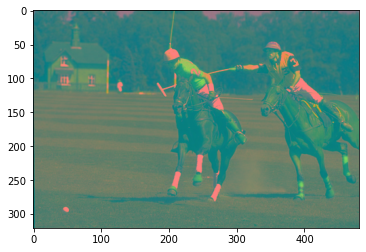

Low resolution image (after cubic interpolation)


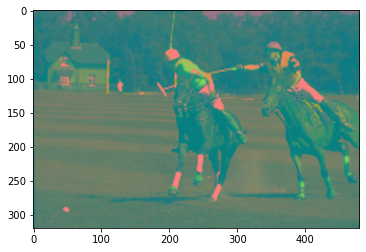

In [ ]:
rand = np.random.choice(len(LRimages), 1)
for x, y in enumerate(rand):
  print('High Resolution / Original image')
  plt.figure()
  plt.imshow(ORimages[y])
  plt.show()
  print('Low resolution image (after cubic interpolation)')
  plt.figure()
  plt.imshow(LRimages[y])

Create LR patches of training and test set, plot 5 LR training images and their corresponding HR images.

Size of LR train patches: 5170
Size of LR test patches: 2670
High resolution images


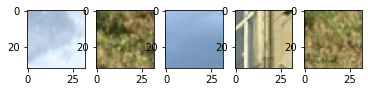

Low resolution images


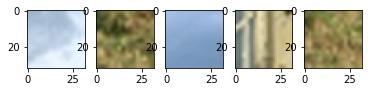

In [ ]:
LRpatches = []
for i in patches:
  LR0img = createLR(i)
  #Create Low resolution photo after cubic interpolation
  LRimg=createCubicInterpolation(LR0img)
  LRpatches.append(LRimg)
print('Size of LR train patches:',len(LRpatches))
 
LRtestpatches=[]
for i in testpatches:
  LR0img = createLR(i)
  LRimg=createCubicInterpolation(LR0img)
  LRtestpatches.append(LRimg)
print('Size of LR test patches:',len(LRtestpatches))

rand = np.random.choice(len(patches), 5)

plt.figure()
print('High resolution images') #original images
for x, y in enumerate(rand):
  plt.subplot(1, 5, x+1)
  plt.imshow(convertYCrCb2RGB(patches[y]))
plt.show()

plt.figure() 
print('Low resolution images') #low resolution images
for x, y in enumerate(rand):
  plt.subplot(1, 5, x+1)
  plt.imshow(convertYCrCb2RGB(LRpatches[y]))

The Y (0th) channel of the original images will be the ground truth. Extract only Yth channel (0) from training, test data and corresponding ground truth. We will use the luminance information (0th channel) only as the input of the CNN



In [ ]:
train = []
trainlabel = []
test = []
testlabel = []

for x in LRpatches:
  train.append(x[:, :, 0])

for y in patches:
  trainlabel.append(y[:, :, 0]) 

for x in LRtestpatches:
   test.append(x[:, :, 0])

for y in testpatches:
  testlabel.append(np.array(y[:, :, 0]))


In [ ]:
#Convert our data to np.arrays
LRImgArr = np.array(LRimages)
ORLabArr = np.array(ORimages) #high resolution
trainArr = np.array(train)
trainlabelArr = np.array(trainlabel)
testArr = np.array(test)
testlabelArr = np.array(testlabel)

#Reshape our data as the tensor requires one more dimension
number, shapeX, shapeY = trainArr.shape
trainArr = trainArr.reshape(number, shapeX, shapeY, 1)
trainlabelArr = trainlabelArr.reshape(number, shapeX, shapeY, 1)

number, shapeX, shapeY = testArr.shape
testArr = testArr.reshape(number, shapeX, shapeY, 1)
testlabelArr = testlabelArr.reshape(number, shapeX, shapeY, 1)


print("Shape of train dataset:", trainArr.shape)
print("Shape of train label dataset:", trainlabelArr.shape)
print("Shape of test dataset:", testArr.shape)
print("Shape of test label dataset:", testlabelArr.shape)


Shape of train dataset: (5170, 32, 32, 1)
Shape of train label dataset: (5170, 32, 32, 1)
Shape of test dataset: (2670, 32, 32, 1)
Shape of test label dataset: (2670, 32, 32, 1)


Normalize the data.


In [ ]:
trainArr = trainArr/ 255.0
trainlabelArr = trainlabelArr / 255.0
testArr = testArr/ 255.0
testlabelArr = testlabelArr/ 255.0

print('Scale of the train samples:', (np.min(trainArr), np.max(trainArr)))
print('Scale of the train labels:', (np.min(trainlabelArr), np.max(trainlabelArr)))
print('Scale of the test samples:', (np.min(testArr), np.max(testArr)))
print('Scale of the test labels:', (np.min(testlabelArr), np.max(testlabelArr)))

Scale of the train samples: (0.0, 1.0)
Scale of the train labels: (0.0, 1.0)
Scale of the test samples: (0.0, 1.0)
Scale of the test labels: (0.0, 1.0)


Split the patches into train and validation data. Use 0.15 part of the train set as the validation set.



In [ ]:
from sklearn.model_selection import train_test_split

train_ds, val_ds, train_lab, val_lab = train_test_split(trainArr, trainlabelArr, test_size = 0.15, shuffle = True)
 
print('Scale of the train samples:', (np.min(train_ds), np.max(train_ds)))
print('Scale of the validation samples:', (np.min(val_ds), np.max(val_ds)))
print('Scale of the train labels:', (np.min(train_lab), np.max(train_lab)))
print('Scale of the validation labels:', (np.min(val_lab), np.max(val_lab)))

print("Shape of train set:", train_ds.shape)
print("Shape of validation set:", val_ds.shape)
print("Shape of test set:", testArr.shape)

Scale of the train samples: (0.0, 1.0)
Scale of the validation samples: (0.0, 1.0)
Scale of the train labels: (0.0, 1.0)
Scale of the validation labels: (0.0, 1.0)
Shape of train set: (4394, 32, 32, 1)
Shape of validation set: (776, 32, 32, 1)
Shape of test set: (2670, 32, 32, 1)


## Define the model
Define the following architecture in tf.keras:
```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 32, 32, 128)       10496     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 1)         1601      
=================================================================
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________
```
* Use 9x9, 3x3 and 5x5 kernels with `relu`, `relu` and `linear` activations in `conv2d`, `conv2d_1` and `conv2d_2`, respectively.
* For optimizer use Adam, and MSE as loss function.


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from skimage.measure import compare_ssim

In [ ]:
# Create model
def my_model(input_size):
  return Sequential([
    Conv2D(128, (9,9), padding='same', activation="relu", input_shape=input_size),
    Conv2D(64, (3,3), padding='same', activation="relu"),
    Conv2D(1, (5,5), padding='same', activation="linear"),
  ])
  
model = my_model(input_size=(32,32,1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       10496     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 1)         1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
model.compile(optimizer="Adam", loss="mse", metrics=["mse"])

## Training and evaluation 
  * Create separate model definitions: one for training small image patches and the other is for predicting on full images.
  * Train the model on the LR image patches for 10 epochs without early stopping.
  * Plot the training curve (train/validation loss and mse).
  * Evaluate the trained model on the test set.
  * Create a prediction model, load the pretrained weights.
  * Plot some (5) examples. (HR, LR [cubic], SR  [prediction] triplets.) 
  * Calculate commonly used super-resolution metrics between HR/LR and HR/SR images. The metrics are: Peak Signal-to-Noise Ratio (PSNR) [20*log10(255/rmse)], Structural Similarity (SSIM) [skimage.measure package, compare_ssim function] and the MSE as well.

*Note: Don't forget to convert the color space from YCrCb back to RGB before plotting and metric calculation.*

 Train the model on the LR image patches for 10 epochs without early stopping.

In [ ]:
checkpoint_path = os.path.join(path, 'cp.ckpt')

# Create callback to save the weights of the model
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(train_ds, train_lab, 
                    batch_size=32, epochs=10, 
                    validation_data=(val_ds, val_lab))

Epoch 1/10
138/138 [==============================] - 2s 17ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 2/10
138/138 [==============================] - 2s 15ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 3/10
138/138 [==============================] - 2s 15ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 4/10
138/138 [==============================] - 2s 15ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 9.4282e-04 - val_mse: 9.4282e-04
Epoch 5/10
138/138 [==============================] - 2s 14ms/step - loss: 9.9449e-04 - mse: 9.9449e-04 - val_loss: 9.1452e-04 - val_mse: 9.1452e-04
Epoch 6/10
138/138 [==============================] - 2s 14ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 8.7646e-04 - val_mse: 8.7646e-04
Epoch 7/10
138/138 [==============================] - 2s 14ms/step - loss: 9.4792e-04 - mse: 9.4792e-04 - val_loss: 8.7034e-04 - val_mse: 8.7034e-04
Epoch 8/10
138/138 [=

Plot training & validation MSE values.


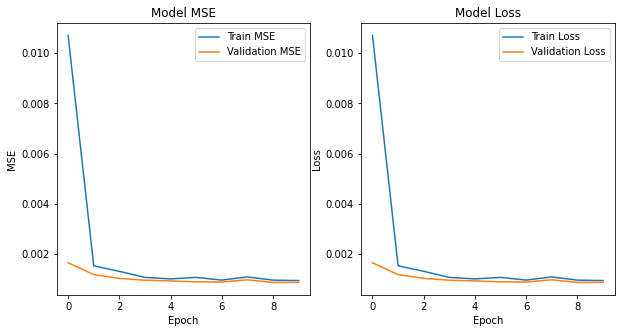

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train MSE', 'Validation MSE'], loc='upper right')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.show()

Evaluate the trained model on the test set.

In [ ]:

print('Evaluate the model on test data')
loss = model.evaluate(testArr, testlabelArr, batch_size=1, verbose=2)
print('test loss:', loss)

Evaluate the model on test data
2670/2670 - 6s - loss: 8.8517e-04 - mse: 8.8517e-04
test loss: [0.0008851741440594196, 0.0008851741440594196]


  Create a prediction model, load the pretrained weights.


In [ ]:
weight = tf.train.latest_checkpoint(os.path.dirname(checkpoint_path))

predmodel = my_model((None, None, 1))
predmodel.load_weights(weight)
predmodel.summary()
predmodel.compile(optimizer= 'adam',
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mse'])


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7264d42e48> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7265e21e10>).
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 1)     1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


 Plot some (5) examples. HR, LR [cubic], SR  [prediction] triplets. Calculate commonly used super-resolution metrics between HR/LR and HR/SR images [PSNR,SSIM,MSE]

In [ ]:
def prediction(predmodel, img):
  #predicted image
  predResult = predmodel.predict(img)
  return predResult

 ***Performance Metrics***
PSNR of HR/LR is 81.62399
PSNR of HR/SR is 63.45323
MSE of predicted image is 0.02936
SSIM of predicted image is 0.49398
 ***Performance Metrics***
PSNR of HR/LR is 80.49904
PSNR of HR/SR is 64.85746
MSE of predicted image is 0.02125
SSIM of predicted image is 0.43706
 ***Performance Metrics***
PSNR of HR/LR is 84.09202
PSNR of HR/SR is 61.98553
MSE of predicted image is 0.04116
SSIM of predicted image is 0.51746
 ***Performance Metrics***
PSNR of HR/LR is 85.39981
PSNR of HR/SR is 66.29649
MSE of predicted image is 0.01526
SSIM of predicted image is 0.65591
 ***Performance Metrics***
PSNR of HR/LR is 81.50245
PSNR of HR/SR is 56.55450
MSE of predicted image is 0.14376
SSIM of predicted image is 0.40813


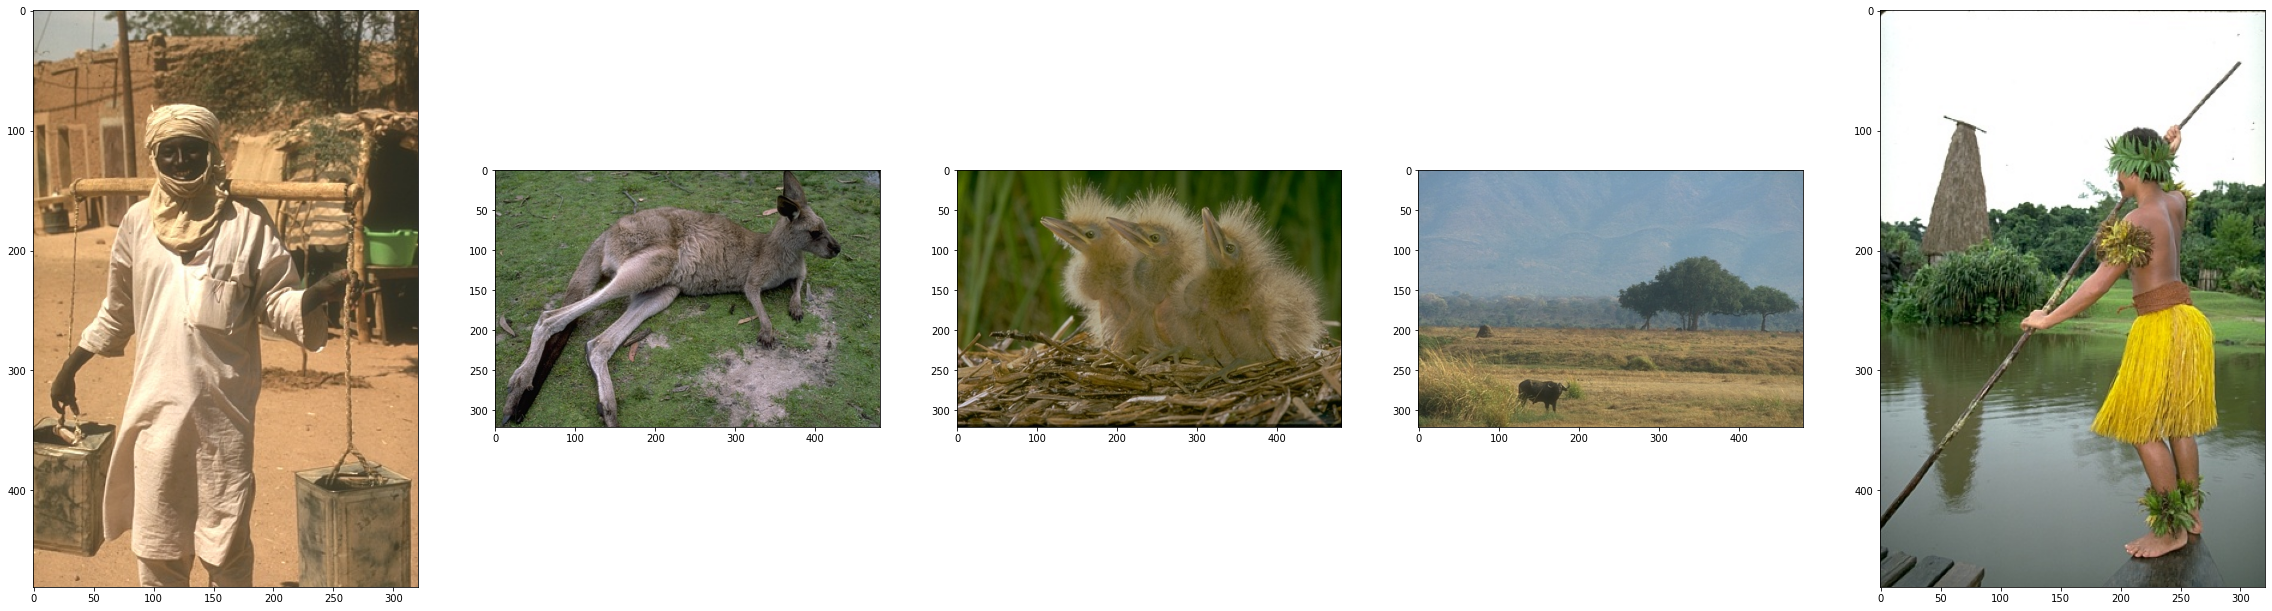

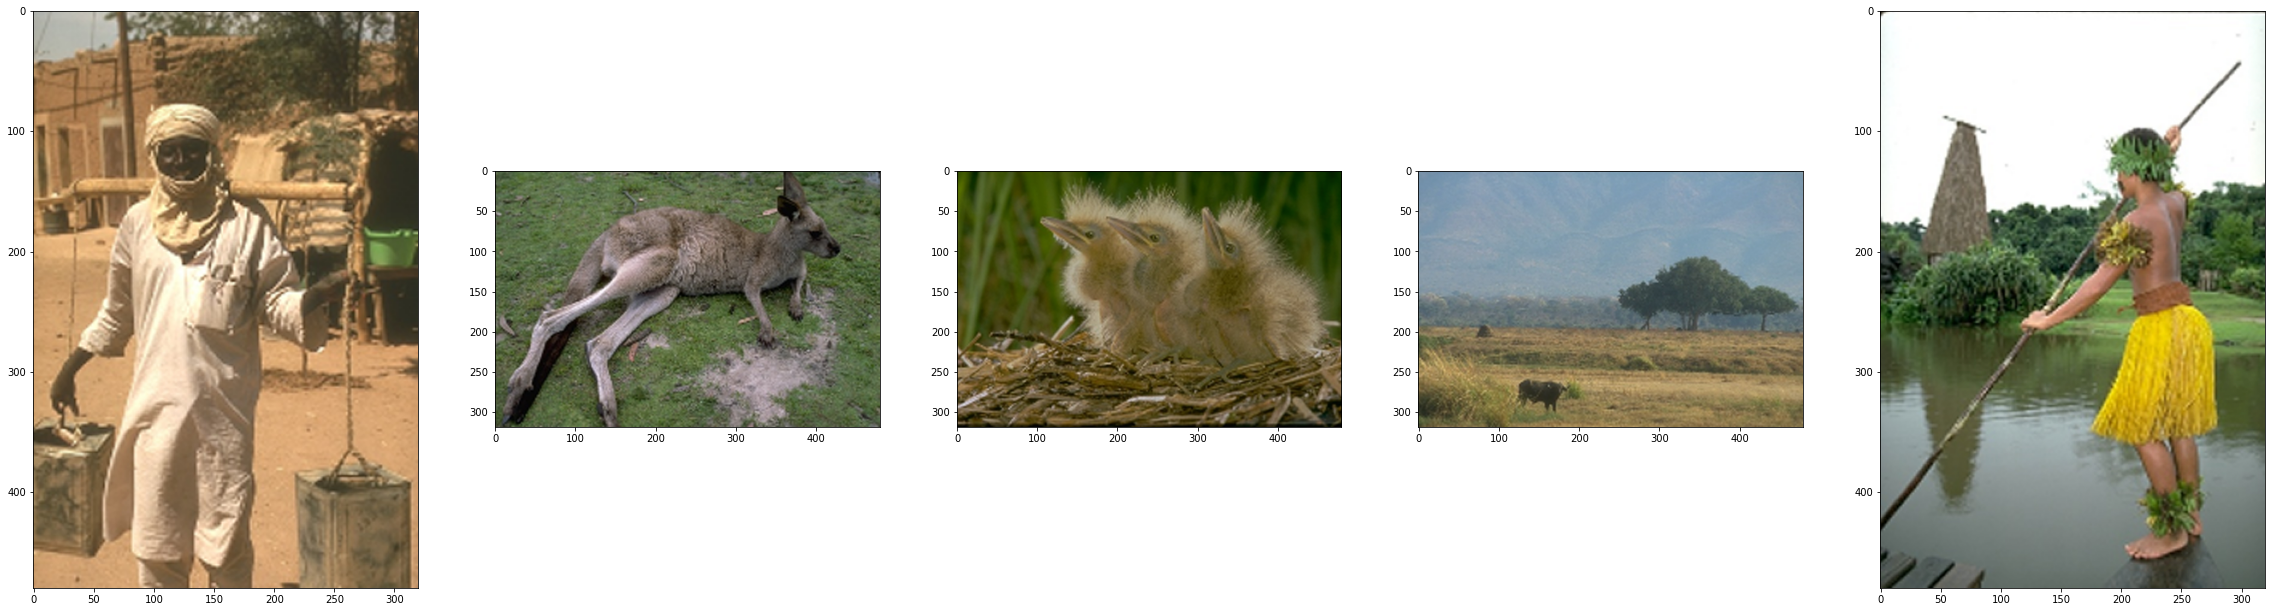

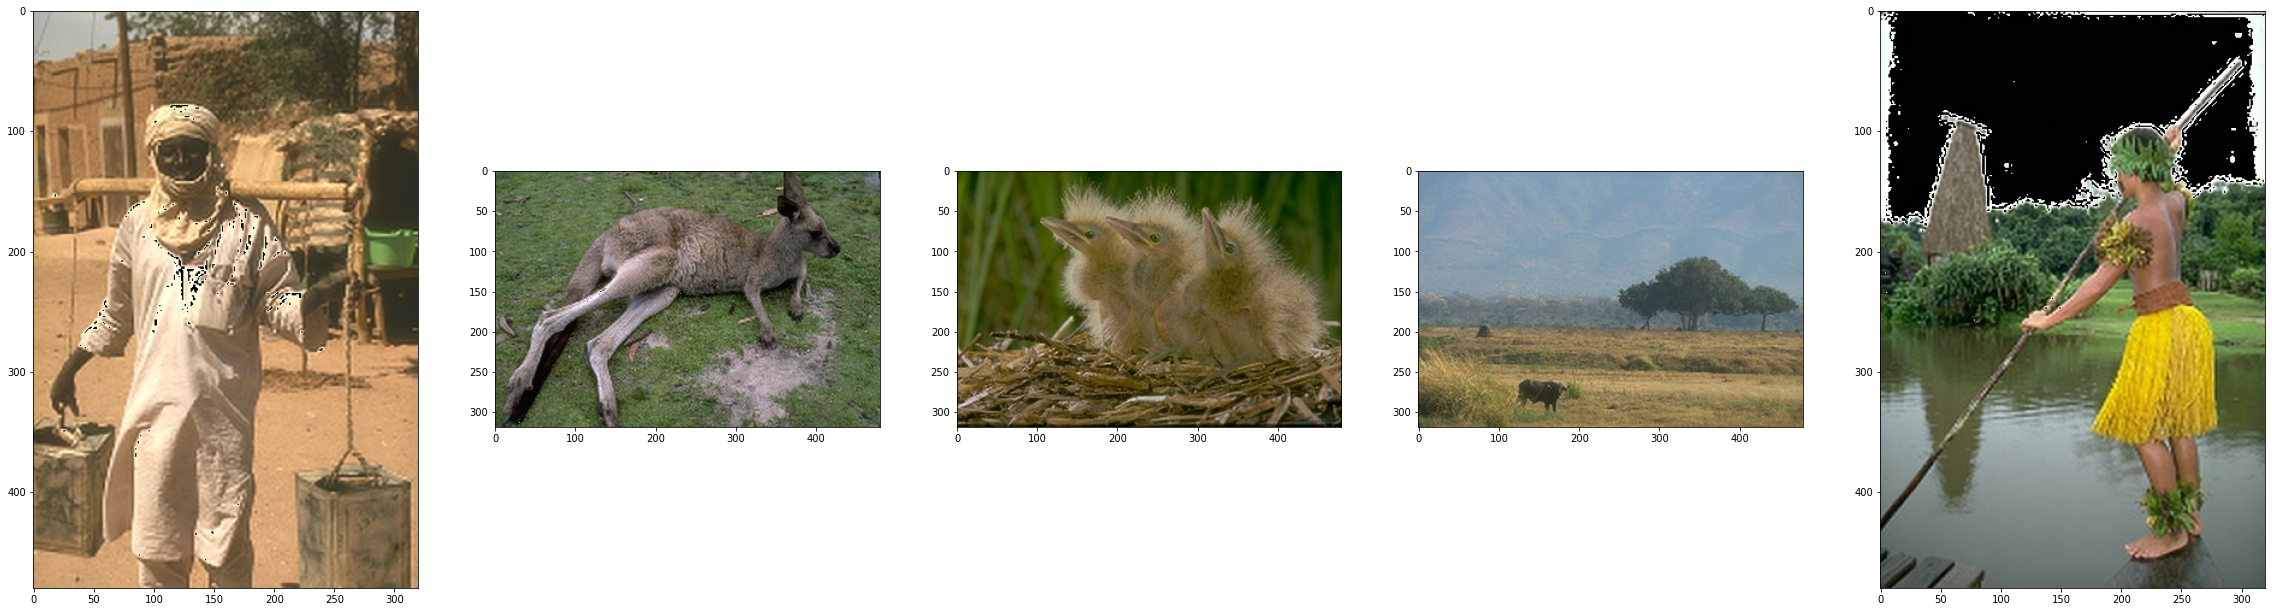

In [ ]:
rand=np.random.choice(len(LRImgArr),5)

plt.figure(figsize = (40,40))
for x,y in enumerate(rand):
  plt.subplot(1,5,x+1)
  img=convertYCrCb2RGB(ORLabArr[y])
  plt.imshow(img)

plt.figure(figsize = (40,40)) 
for x,y in enumerate(rand):
  plt.subplot(1,5,x+1)
  img=convertYCrCb2RGB(LRImgArr[y])
  plt.imshow(img)

MSE = 0
SSIM = 0
HR_LR_PSNR = 0
HR_SR_PSNR = 0
plt.figure(figsize = (40,40)) 
for i,j in enumerate(rand):
  yLR, CrLR, CbLR = cv2.split(LRImgArr[j])
  shapeX, shapeY = yLR.shape
  y = yLR.reshape(1, shapeX, shapeY, 1)
  y = y / 255
  predimg = prediction(predmodel, y)
  x, y, z, f = predimg.shape
  imgY = predimg.reshape(y, z)
  imgY = imgY * 255
  imgY = PIL.Image.fromarray(np.uint8(imgY))
  imgCr = PIL.Image.fromarray(np.uint8(CrLR))
  imgCb = PIL.Image.fromarray(np.uint8(CbLR))
  finalimg = PIL.Image.merge('YCbCr',(imgY, imgCb, imgCr)).convert("RGB")
  plt.subplot(1, 5, i+1)
  plt.imshow(finalimg)
  #Performance metrics
  w,h,z = ORLabArr[j].shape
  lr = LRImgArr[j] / 255
  lr = cv2.resize(lr, (h,w))
  finalimg = finalimg.resize((h,w))
  finalimg = img_to_array(finalimg) / 255
  HR_LR_PSNR = tf.image.psnr(lr, ORLabArr[j] / 255, max_val = 255)
  HR_SR_PSNR = tf.image.psnr(finalimg, ORLabArr[j] / 255, max_val = 255)
  MSE = mean_squared_error(finalimg, ORLabArr[j] / 255)
  SSIM = ssim(finalimg, ORLabArr[j] / 255, data_range=finalimg.max()-finalimg.min(), multichannel=True)
  print(" ***Performance Metrics***")
  print("PSNR of HR/LR is %.5f" % HR_LR_PSNR)
  print("PSNR of HR/SR is %.5f" % HR_SR_PSNR)
  print("MSE of predicted image is %.5f" % MSE)
  print("SSIM of predicted image is %.5f" % SSIM)